In [1]:
# Importing packages
import os
import pandas as pd
# tf tools
import tensorflow as tf
# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10
# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD
#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
# for plotting
import numpy as np
import matplotlib.pyplot as plt

2023-05-23 12:15:53.044866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
test_metadata = pd.read_json(os.path.join("..", "images", "metadata", "test_data.json"), lines = True)
test_metadata.head()
test_metadata.shape

(7500, 6)

In [25]:
#test_metadata = test_metadata.groupby("class_label").apply(lambda x: x.sample(frac=0.5))
#test_metadata.set_index('class_label')

test_metadata = test_metadata.groupby("class_label").sample(frac=0.5)
test_metadata.tail()
test_metadata.shape


(3750, 6)

In [4]:
def load_data():
    # converting the metadata into Pandas objects
        # !!! NTS remember to change ".." to "data" in final version
        test_metadata = pd.read_json(os.path.join("..", "images", "metadata", "test_data.json"), lines = True)
        train_metadata = pd.read_json(os.path.join("..", "images", "metadata", "train_data.json"), lines = True)
        val_metadata = pd.read_json(os.path.join("..", "images", "metadata", "val_data.json"), lines = True)

        # !!! (TRY ALSO VALIDATION)
        train_metadata = train_metadata.sample(frac=0.01)
        test_metadata = test_metadata.sample(frac=0.01)
        val_metadata = val_metadata.sample(frac=0.01)

        # changing the column with the image path from a relative path to an absolute path
        test_metadata["image_path"] = "/work/" + test_metadata["image_path"]
        train_metadata["image_path"] = "/work/" + train_metadata["image_path"]
        val_metadata["image_path"] = "/work/" + val_metadata["image_path"]

        # Defining data generater
        # flip along x axis (mirror image)
        datagen = ImageDataGenerator(horizontal_flip=True, 
                                    rotation_range=20,
                                    validation_split=0.1)

        # splitting the data into train, test and validation by using "flow_from_dataframe"
        # source: code adapted from Kaggle-user vencerlanz09 
        # (link to source: https://www.kaggle.com/code/vencerlanz09/indo-fashion-classification-using-efficientnetb0)
        BATCH_SIZE = 32
        TARGET_SIZE = (224, 224)
        train_images = datagen.flow_from_dataframe(
            dataframe=train_metadata,
            #directory = os.path.join("..", "images", "train"),
            x_col='image_path',
            y_col='class_label',
            target_size=TARGET_SIZE,
            color_mode='rgb',
            class_mode='categorical',
            batch_size=BATCH_SIZE,
            shuffle=True,
            seed=42,
            subset='training')

        val_images = datagen.flow_from_dataframe(
            dataframe=val_metadata,
            #directory = os.path.join("..", "images", "val"),
            x_col='image_path',
            y_col='class_label',
            target_size=TARGET_SIZE,
            color_mode='rgb',
            class_mode='categorical',
            batch_size=BATCH_SIZE,
            shuffle=True,
            seed=42)

        test_images = datagen.flow_from_dataframe(
            dataframe=test_metadata,
            #directory = os.path.join("..", "images", "test"),
            x_col='image_path',
            y_col='class_label',
            target_size=TARGET_SIZE,
            color_mode='rgb',
            class_mode='categorical',
            batch_size=BATCH_SIZE,
            shuffle=False)

        # assigning labels by getting unique labels from the class column
        label_names = test_metadata['class_label'].unique()
        
        return label_names, train_images, val_images, test_images, test_metadata

In [11]:
label_names, train_images, val_images, test_images, test_metadata = load_data()

Found 821 validated image filenames belonging to 15 classes.
Found 75 validated image filenames belonging to 15 classes.
Found 75 validated image filenames belonging to 15 classes.


In [6]:
def load_model():
    # load model without classifier layers
    model = VGG16(include_top=False, 
                pooling='avg',
                input_shape=(32, 32, 3))

    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
        
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    bn = BatchNormalization()(flat1) # NTS : removed one layer
    class1 = Dense(128, 
                activation='relu')(bn)
    output = Dense(15, 
                activation='softmax')(class1) # NTS: changed from 10 to 15 (number of classes)

    # define new model
    model = Model(inputs=model.inputs, 
                outputs=output)

    # compile
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=10000,
        decay_rate=0.9)
    sgd = SGD(learning_rate=lr_schedule)

    model.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

In [10]:
model = load_model()

In [8]:
def train_clf(model, train_images, val_images):
    H = model.fit(train_images, 
            validation_data = val_images,
            batch_size=128,
            epochs=2, # CHANGED FROM 10 FOR TESTING
            verbose=1)

    return H, model

In [12]:
H, model = train_clf(model, train_images, val_images)

Epoch 1/2


2023-05-18 17:54:51.250494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - ETA: 0s - loss: 2.8957 - accuracy: 0.1559

2023-05-18 17:56:14.295002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - 89s 3s/step - loss: 2.8957 - accuracy: 0.1559 - val_loss: 4.1555 - val_accuracy: 0.1333
Epoch 2/2
26/26 [==============================] - 27s 1s/step - loss: 2.2644 - accuracy: 0.3082 - val_loss: 3.0735 - val_accuracy: 0.1867


In [13]:
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    # save the plot
    plt.savefig(os.path.join("out", "history_plt.png"))

/tmp/ipykernel_999/2319498549.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


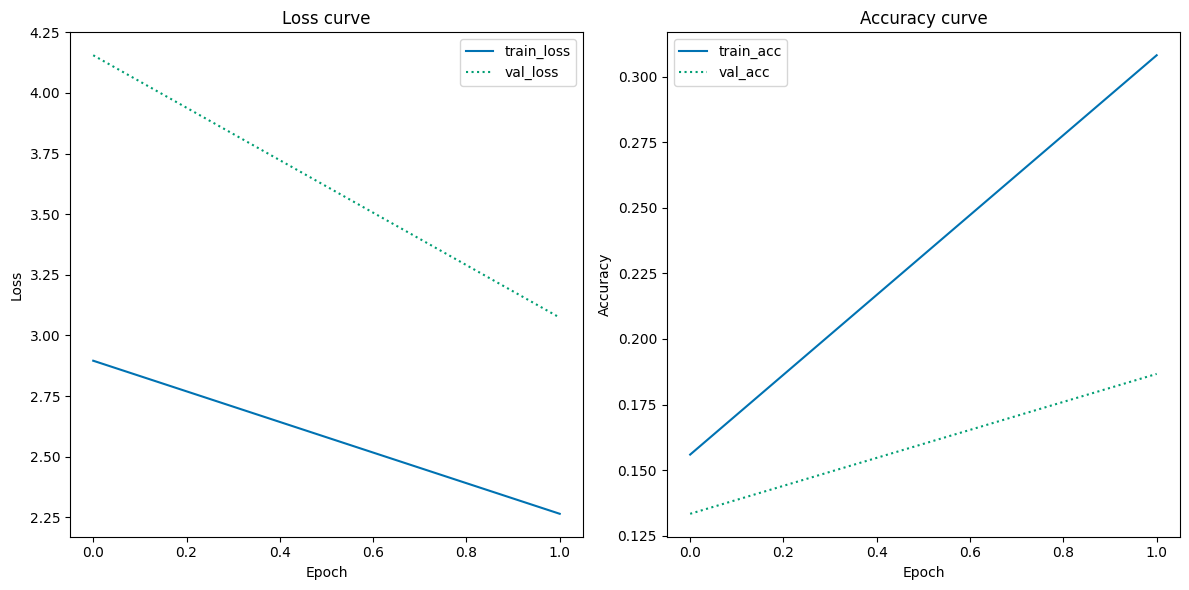

In [14]:
plot_history(H, 2)

In [25]:
def clf_report(model, test_images, test_metadata, label_names):
    predictions = model.predict(test_images, batch_size=128)
    predictions = np.argmax(predictions, axis=1)
    # generating predictions
    predictions = [label_names[k] for k in predictions] # NTS: NEW
    y_test = list(test_metadata.class_label) # (new)
    clf_report = classification_report(y_test, # removed: .argmax(axis=1)
                            predictions, # removed: .argmax(axis=1)
                            target_names=label_names)
    # clf_report = print(clf_report)
    # save the classification report
    txtfile_path = os.path.join("out", "clf_report.txt")
    txtfile = open(txtfile_path, "w")
    txtfile.write(str(clf_report))
    txtfile.close

In [26]:
clf_report(model, test_images, test_metadata, label_names)

2023-05-18 18:06:44.413008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 3s 685ms/step


/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
